In [1]:
import tensorflow as tf
from keras.layers import Dense
from keras.models import Sequential

from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline

SEED = 34



In [2]:
# 데이터를 train에서 사람 이미지 한장과 label 정보 한개를 불러오는 코드
# (x, y로 변수 대입)
celeba_small = np.load('data_celeba.npz')
x,y=celeba_small['X_data'],celeba_small['Y_data']

In [3]:
x.shape, y.shape

((2000, 72, 59, 3), (2000, 2))

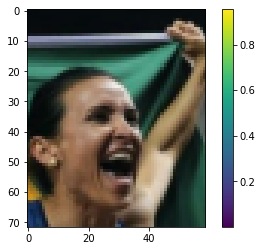

[[0 0]
 [1 1]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]


In [4]:
plt.imshow(next(iter(x)))
plt.colorbar()
plt.show()
print(y)

In [5]:
# celeba_small.npz에서 train_images, test_images, train_labels, test_labels를 np array로 로드

from sklearn.model_selection import train_test_split

train_images, test_images, train_labels, test_labels = train_test_split(x,y, 
                                                  test_size = 0.3, random_state = 777)

print(train_images.shape, len(train_labels))
print(test_images.shape, len(test_labels))


(1400, 72, 59, 3) 1400
(600, 72, 59, 3) 600


In [6]:
# 하나의 이미지에 대한 모든 0이 아닌 값을 출력하는 코드
train_images[train_images != 0][:10]

array([0.92941176, 0.9254902 , 0.94901961, 0.92941176, 0.9254902 ,
       0.94901961, 0.92941176, 0.9254902 , 0.94901961, 0.92941176])

In [7]:
# dtype을 이용하여 이미지의 np array type을 확인
train_images.dtype

dtype('float64')

In [8]:
# 이미지 데이터 범위확인
print(train_images.shape, test_images.shape)
print(train_images.dtype, test_images.dtype)

print(train_labels.shape, test_labels.shape)
print(train_labels.dtype, test_labels.dtype)

print(train_images[train_images != 0][:10])
print(test_images[test_images != 0][:10])

(1400, 72, 59, 3) (600, 72, 59, 3)
float64 float64
(1400, 2) (600, 2)
int8 int8
[0.92941176 0.9254902  0.94901961 0.92941176 0.9254902  0.94901961
 0.92941176 0.9254902  0.94901961 0.92941176]
[0.07058824 0.03529412 0.02356265 0.09019608 0.0628448  0.05108009
 0.06616816 0.05456962 0.04297109 0.04313725]


In [9]:
# train/test 전체 데이터에서 각 images, labels의 min, max를 출력
print(train_images.min(), train_images.max())
print(train_labels.min(), train_labels.max())

0.0 1.0
0 1


In [10]:
# (배치, 2)의 labels shape을 (배치, 1)의 shape의 2개의 array로 분리하는 코드
from keras.utils import to_categorical
train_male_labels, train_smile_labels = np.split(train_labels, 2, axis=1)
test_male_labels, test_smile_labels = np.split(test_labels, 2, axis=1)

print(train_male_labels.shape, train_smile_labels.shape)
print(train_male_labels[0], train_smile_labels[0], train_labels[0])

#  (배치, 2) ->  (배치, 1),  (배치, 1) -> (배치, 2),  (배치, 2) 

(1400, 1) (1400, 1)
[0] [0] [0 0]


In [11]:
train_male_labels = to_categorical(train_male_labels)
train_smile_labels = to_categorical(train_smile_labels)
test_male_labels = to_categorical(test_male_labels)
test_smile_labels = to_categorical(test_smile_labels)

In [12]:
print(train_male_labels.shape, train_smile_labels.shape)
print(test_male_labels.shape, test_smile_labels.shape)

(1400, 2) (1400, 2)
(600, 2) (600, 2)


In [13]:
# (배치, 2), (배치, 2)의 labels를 (배치, 4)로 합치는 코드
# (배치, 남성여부, 웃음여부) => (배치, 남성여부), (배치, 웃음여부) => (배치, 여자여부, 남자여부), (배치, 안웃음여부, 웃음여부) => (배치, 여자여부, 남자여부, 안웃음여부, 웃음여부)
train_labels2 = np.concatenate([train_male_labels, train_smile_labels], axis = 1)
test_labels2 = np.concatenate([test_male_labels, test_smile_labels], axis = 1)
print(train_labels2.shape, test_labels2.shape)

(1400, 4) (600, 4)


In [14]:
# (배치, 세로, 가로, 3)인 train_images에서 (5, 세로, 가로, 3)을 획득하는 코드
train_images[:5].shape

(5, 72, 59, 3)

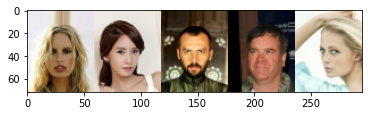

[[1. 0. 1. 0.]
 [1. 0. 1. 0.]
 [0. 1. 1. 0.]
 [0. 1. 0. 1.]
 [1. 0. 1. 0.]]


In [15]:
# np.hstack은 height 방향의 배열을 풀어서 width 방향으로 연결해줍니다.
# 해당 기능을 쓰면 (height, image_height, image_width, color)의 shape을 (image_height, image_width * height, color)으로 바꿔 줄 수 있습니다.

plt.imshow(np.hstack(train_images[:5]))
plt.show()
print(train_labels2[:5])

<AxesSubplot:xlabel='gender'>

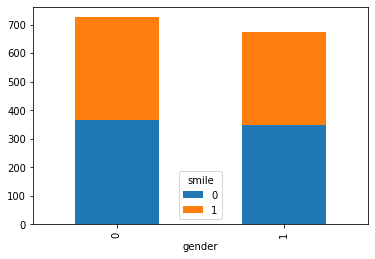

In [16]:
# pandas를 smile, male이 각각 몇개 있는지 plt를 통하여 출력하는 코드
df = pd.DataFrame(train_labels, columns = ['gender', 'smile'])
df.groupby(['gender', 'smile']).size().unstack().plot(kind='bar', stacked=True)

##  멀티 아웃풋 모델링

In [27]:
# input (배치, 72, 59, 3), output (배치, 2)을 처리할 수 있는 모양의 모델을 작성하세요.
from keras.models import Model
from keras.layers import Conv2D, MaxPool2D, Input, Dense, Flatten, Concatenate

def multi_model():
  inputs = Input((72, 59, 3))

  l1 = Conv2D(32, 3, activation='relu')(inputs)
  l2 = MaxPool2D(2)(l1)
  l3 = Conv2D(64, 3, activation='relu')(l2)
  l4 = MaxPool2D(2)(l3)
  l5 = Conv2D(64, 3, activation='relu')(l4)
  l6 = MaxPool2D(2)(l5)
  
  l7 = Flatten()(l6)
  latent_vector = Dense(64, activation='relu')(l7)

  gender_outputs = Dense(2, activation='softmax')(latent_vector)
  smile_outputs = Dense(2, activation='softmax')(latent_vector)

  outputs = Concatenate(axis=1)([gender_outputs, smile_outputs])
  model = Model(inputs, outputs)
  #model = Model(inputs, [gender_outputs, smile_outputs])
  return model

def multi_model2():
  inputs = Input((72, 59, 3))

  l1 = Conv2D(32, 3, activation='relu')(inputs)
  l2 = MaxPool2D(2)(l1)
  l3 = Conv2D(64, 3, activation='relu')(l2)
  l4 = MaxPool2D(2)(l3)
  l5 = Conv2D(64, 3, activation='relu')(l4)
  l6 = MaxPool2D(2)(l5)
  
  l7 = Flatten()(l6)
  latent_vector = Dense(64, activation='relu')(l7)

  gender_outputs = Dense(2, activation='softmax')(latent_vector)
  smile_outputs = Dense(2, activation='softmax')(latent_vector)

  outputs = Concatenate(axis=1)([gender_outputs, smile_outputs])
  #model = Model(inputs, outputs)
  model = Model(inputs, [gender_outputs, smile_outputs])
  return model

In [40]:
model = multi_model()
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 72, 59, 3)]  0           []                               
                                                                                                  
 conv2d_9 (Conv2D)              (None, 70, 57, 32)   896         ['input_4[0][0]']                
                                                                                                  
 max_pooling2d_9 (MaxPooling2D)  (None, 35, 28, 32)  0           ['conv2d_9[0][0]']               
                                                                                                  
 conv2d_10 (Conv2D)             (None, 33, 26, 64)   18496       ['max_pooling2d_9[0][0]']        
                                                                                            

In [41]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [30]:
model2 = multi_model2()
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 72, 59, 3)]  0           []                               
                                                                                                  
 conv2d_6 (Conv2D)              (None, 70, 57, 32)   896         ['input_3[0][0]']                
                                                                                                  
 max_pooling2d_6 (MaxPooling2D)  (None, 35, 28, 32)  0           ['conv2d_6[0][0]']               
                                                                                                  
 conv2d_7 (Conv2D)              (None, 33, 26, 64)   18496       ['max_pooling2d_6[0][0]']        
                                                                                            

In [35]:
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [42]:
hist1 = model.fit(train_images, train_labels2, 
                  validation_data=(test_images, test_labels2), 
                  epochs=15, verbose=1)

Epoch 1/15
44/44 [==============================] - 1s 15ms/step - loss: 2.7325 - accuracy: 0.3557 - val_loss: 2.6154 - val_accuracy: 0.5800
Epoch 2/15
44/44 [==============================] - 0s 7ms/step - loss: 2.5497 - accuracy: 0.5957 - val_loss: 2.5389 - val_accuracy: 0.5350
Epoch 3/15
44/44 [==============================] - 0s 7ms/step - loss: 2.4255 - accuracy: 0.6207 - val_loss: 2.4142 - val_accuracy: 0.6733
Epoch 4/15
44/44 [==============================] - 0s 7ms/step - loss: 2.2557 - accuracy: 0.6364 - val_loss: 2.3063 - val_accuracy: 0.6617
Epoch 5/15
44/44 [==============================] - 0s 6ms/step - loss: 2.1186 - accuracy: 0.6221 - val_loss: 2.2486 - val_accuracy: 0.6150
Epoch 6/15
44/44 [==============================] - 0s 6ms/step - loss: 1.9960 - accuracy: 0.6243 - val_loss: 2.0926 - val_accuracy: 0.6283
Epoch 7/15
44/44 [==============================] - 0s 6ms/step - loss: 1.8852 - accuracy: 0.6171 - val_loss: 2.0716 - val_accuracy: 0.6100
Epoch 8/15
44/44 [=

In [25]:
np.concatenate([train_male_labels,train_smile_labels], axis=1)

array([[1., 0., 1., 0.],
       [1., 0., 1., 0.],
       [0., 1., 1., 0.],
       ...,
       [0., 1., 1., 0.],
       [1., 0., 1., 0.],
       [1., 0., 1., 0.]], dtype=float32)

In [37]:
hist2= model2.fit(train_images, [train_male_labels,train_smile_labels], 
                  validation_data=(test_images, [test_male_labels, test_smile_labels]), 
                  epochs=15, verbose=1)

Epoch 1/15
44/44 [==============================] - 1s 13ms/step - loss: 1.3305 - dense_7_loss: 0.6400 - dense_8_loss: 0.6904 - dense_7_accuracy: 0.6179 - dense_8_accuracy: 0.5271 - val_loss: 1.2131 - val_dense_7_loss: 0.5230 - val_dense_8_loss: 0.6900 - val_dense_7_accuracy: 0.7467 - val_dense_8_accuracy: 0.5417
Epoch 2/15
44/44 [==============================] - 0s 7ms/step - loss: 1.1602 - dense_7_loss: 0.5067 - dense_8_loss: 0.6535 - dense_7_accuracy: 0.7621 - dense_8_accuracy: 0.6007 - val_loss: 1.1949 - val_dense_7_loss: 0.5042 - val_dense_8_loss: 0.6907 - val_dense_7_accuracy: 0.7800 - val_dense_8_accuracy: 0.5317
Epoch 3/15
44/44 [==============================] - 0s 7ms/step - loss: 1.0473 - dense_7_loss: 0.4403 - dense_8_loss: 0.6070 - dense_7_accuracy: 0.7864 - dense_8_accuracy: 0.6614 - val_loss: 1.0833 - val_dense_7_loss: 0.4732 - val_dense_8_loss: 0.6101 - val_dense_7_accuracy: 0.7650 - val_dense_8_accuracy: 0.6600
Epoch 4/15
44/44 [==============================] - 0s 7m

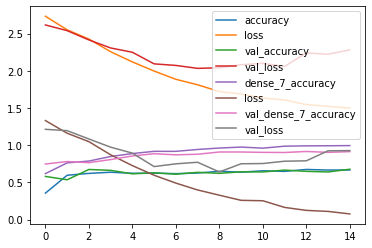

In [47]:

plt.plot(hist1.history['accuracy'], label = 'accuracy')
plt.plot(hist1.history['loss'], label = 'loss')
plt.plot(hist1.history['val_accuracy'], label = 'val_accuracy')
plt.plot(hist1.history['val_loss'], label = 'val_loss')
plt.plot(hist2.history['dense_7_accuracy'], label = 'dense_7_accuracy')
plt.plot(hist2.history['loss'], label = 'loss')
plt.plot(hist2.history['val_dense_7_accuracy'], label = 'val_dense_7_accuracy')
plt.plot(hist2.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

In [45]:
hist2.history.keys()

dict_keys(['loss', 'dense_7_loss', 'dense_8_loss', 'dense_7_accuracy', 'dense_8_accuracy', 'val_loss', 'val_dense_7_loss', 'val_dense_8_loss', 'val_dense_7_accuracy', 'val_dense_8_accuracy'])

1/1 [==============================] - 0s 354ms/step


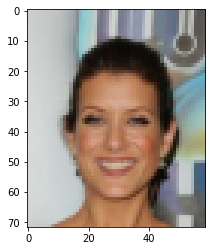

In [48]:
# 모델에 test_mages 중 1장을 넣고 결과를 받는 코드
res = model.predict(test_images[2:3])
#print(res[0].shape, res[1].shape)
plt.imshow(test_images[2])



## 모델 분리

In [49]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 72, 59, 3)]  0           []                               
                                                                                                  
 conv2d_9 (Conv2D)              (None, 70, 57, 32)   896         ['input_4[0][0]']                
                                                                                                  
 max_pooling2d_9 (MaxPooling2D)  (None, 35, 28, 32)  0           ['conv2d_9[0][0]']               
                                                                                                  
 conv2d_10 (Conv2D)             (None, 33, 26, 64)   18496       ['max_pooling2d_9[0][0]']        
                                                                                            

In [50]:
gender_model2 = Model(inputs = model.input, outputs = model.get_layer('dense_11').output)
gender_model2.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 72, 59, 3)]       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 70, 57, 32)        896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 35, 28, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 33, 26, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 16, 13, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 14, 11, 64)        3692

In [51]:
# 성별모델에서 테스트 데이터 확인
x = gender_model2.predict(test_images[0:1])
x.argmax()

1/1 [==============================] - 0s 27ms/step


1

### [미션]  smile모델을 분리하여 작업후 smile 모델에서 사진 확인해봄